<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Data-download" data-toc-modified-id="Data-download-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data download</a></span><ul class="toc-item"><li><span><a href="#community" data-toc-modified-id="community-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>community</a></span></li><li><span><a href="#trees" data-toc-modified-id="trees-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>trees</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Metagenome-samples" data-toc-modified-id="Metagenome-samples-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Metagenome samples</a></span></li><li><span><a href="#Trees" data-toc-modified-id="Trees-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Trees</a></span></li></ul></li><li><span><a href="#Formatting" data-toc-modified-id="Formatting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Formatting</a></span><ul class="toc-item"><li><span><a href="#Subsampling" data-toc-modified-id="Subsampling-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Subsampling</a></span></li><li><span><a href="#Filtering-trees" data-toc-modified-id="Filtering-trees-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Filtering trees</a></span></li></ul></li><li><span><a href="#Calculate-alpha-diversity" data-toc-modified-id="Calculate-alpha-diversity-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Calculate alpha diversity</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Calculate-MPD-&amp;-MNTD" data-toc-modified-id="Calculate-MPD-&amp;-MNTD-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Calculate MPD &amp; MNTD</a></span><ul class="toc-item"><li><span><a href="#MNTD" data-toc-modified-id="MNTD-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>MNTD</a></span></li><li><span><a href="#MPD" data-toc-modified-id="MPD-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>MPD</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Beta-diversity" data-toc-modified-id="Beta-diversity-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Beta diversity</a></span><ul class="toc-item"><li><span><a href="#PCoA" data-toc-modified-id="PCoA-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>PCoA</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Tutorial on calculating tree-based alpha diversity for Kraken2/Bracken metagenome data
  * Associated data: a genome phylogeny based on the GTDB data
  * ftp server: http://ftp.tue.mpg.de/ebio/

# Var

In [1]:
# working directory
work_dir = '/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial/'

# url for the FTP server
ftp_url = 'http://ftp.tue.mpg.de/ebio/nyoungblut/gmd/'

# community files
## Kraken2/Bracken counts
brk_file = file.path(ftp_url, 'bracken.qs')
## sample metadata
meta_file = file.path(ftp_url, 'sample_metadata.tsv')

# tree files
## genome phylogeny (GTDB)
phy_file = file.path(ftp_url, 'GTDBr89_ar122-bac120.nwk')
## predicted traits in each species genome representative
trt_file = file.path(ftp_url, 'predictions_flat_majority-votes_combined_jaccard_rn.nwk')
## genes per COG in each species genome repesentative
cog_file = file.path(ftp_url, 'genes-per-COG_UniRef90_bray.nwk')
## genes per Pfam in each species genome repesentative
pfam_file = file.path(ftp_url, 'genes-per-pfam_UniRef90_bray.nwk')

# params
threads = 4

# Init

In [57]:
# required packages
library(dplyr)
library(tidyr)
library(ggplot2)
library(qs)
library(ape)
library(vegan)
library(PhyloMeasures)

In [3]:
# setup
dir.create(work_dir, recursive = TRUE, showWarnings = FALSE)
random_seed = 9381

In [4]:
# pretty-print of tables in jupyter
df.dims = function (nrows = 4, ncols = 20){
    options(repr.matrix.max.rows = nrows, repr.matrix.max.cols = ncols)
}
df.dims()

In [58]:
# pretty-print of plots in jupyter
p.dims = function (w = 5, h = 5, res = 200){
    options(repr.plot.width = w, repr.plot.height = h, repr.plot.res = res)
}

# Data download

In [5]:
#' wrapper function for downloading file
download_file = function(url, dest_dir){
    destfile = file.path(dest_dir, basename(url))
    utils::download.file(url, destfile)
    return(destfile)
}

## community

In [6]:
# Bracken counts
brk_file = download_file(brk_file, work_dir)
brk_file

[1] "/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial//bracken.qs"

In [7]:
# Sample metadata
meta_file = download_file(meta_file, work_dir)
meta_file

[1] "/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial//sample_metadata.tsv"

## trees

In [8]:
phy_file = download_file(phy_file, work_dir)
phy_file

[1] "/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial//GTDBr89_ar122-bac120.nwk"

In [9]:
trt_file = download_file(trt_file, work_dir)
trt_file

[1] "/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial//predictions_flat_majority-votes_combined_jaccard_rn.nwk"

In [10]:
cog_file = download_file(cog_file, work_dir)
cog_file

[1] "/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial//genes-per-COG_UniRef90_bray.nwk"

In [11]:
pfam_file = download_file(pfam_file, work_dir)
pfam_file

[1] "/ebio/abt3_projects2/global_metagenome_diversity/data/tutorial//genes-per-pfam_UniRef90_bray.nwk"

# Load

## Metagenome samples

In [12]:
# bracken counts
brk = qs::qread(brk_file)
brk 

dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CosteaPI_2017,s__Caecibacter_massiliensis,108259,S,Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Megasphaeraceae,Caecibacter,Caecibacter massiliensis,halbarad.11.0.0,0
CosteaPI_2017,s__UBA1777_sp002350825,178550,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,UBA1777,UBA1777 sp002350825,halbarad.11.0.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Serratia_grimesii,121568,S,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Serratia,Serratia grimesii,SZAXPI017592.142,0
YuJ_2015,s__Bacteroides_A_sp002161565,119189,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_A,Bacteroides_A sp002161565,SZAXPI017592.142,0


In [13]:
# sample metadata
meta = read.delim(meta_file, sep='\t') %>%
    select(Sample, dataset_name, subjectID, study_condition, 
              disease, age, gender, BMI, westernized) 
meta 

Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
TRAVELRES1,Bengtsson-PalmeJ_2015,TRAVELRES1_2,control,healthy,25,female,NA,TRUE
TRAVELRES11,Bengtsson-PalmeJ_2015,TRAVELRES11_12,control,healthy,22,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PNP_Validation_45,ZeeviD_2015,PNP_Validation_45,control,healthy,NA,,NA,TRUE
PNP_Validation_46,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,,NA,TRUE


## Trees

In [14]:
# Genome phylogeny
gtdb_phy = ape::read.tree(phy_file)
gtdb_phy


Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
  s__Halorubrum_sp000296615, s__Halorubrum_distributum, s__Halorubrum_trapanicum, s__Halorubrum_tropicale, s__Halorubrum_coriense, s__Halorubrum_ezzemoulense, ...
Node labels:
  100.0, d__Archaea100.0, 97.0, 99.0, 100.0, 100.0-p__Halobacterota, ...

Rooted; includes branch lengths.

In [15]:
# traitar trait dendrogram
trt_phy = read.tree(trt_file)
trt_phy


Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
  s__Mikella_endobia, s__Prochlorococcus_B_sp003284185, s__Prochlorococcus_A_sp003282425, s__Eperythrozoon_A_wenyonii_A, s__GN02-872_sp003260325, s__SZUA-486_sp003251635, ...

Rooted; includes branch lengths.

In [16]:
# cog dendrogram
cog_phy = read.tree(cog_file)
cog_phy


Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
  s__UBA9959_sp001799795, s__2-02-FULL-45-21_sp001805845, s__UBA11600_sp002717745, s__UBA11600_sp002714165, s__UBA11600_sp002730735, s__LS-NOB_sp002705185, ...

Rooted; includes branch lengths.

In [17]:
# pfam dendrogram
pfam_phy = read.tree(pfam_file)
pfam_phy


Phylogenetic tree with 23358 tips and 23357 internal nodes.

Tip labels:
  s__Acinetobacter_gerneri, s__Enterococcus_sp002174455, s__Cnuella_takakiae, s__Marinomonas_primoryensis, s__Kosakonia_oryzendophytica, s__Roseomonas_cervicalis, ...

Rooted; includes branch lengths.

# Formatting

## Subsampling

* To speed up the calculations

In [18]:
# filtering by metadata
meta_f = meta %>%
    filter(dataset_name == 'LiJ_2017') %>%
    mutate(X = sample(1:length(Sample), length(Sample))) %>%
    filter(X <= 100) %>%
    select(-X)
meta_f$disease %>% table
meta_f

.
     healthy hypertension 
          22           78 

Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
H1F512951,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
H1M313811,LiJ_2017,H1M313811,pre-hypertension,hypertension,NA,,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612743,LiJ_2017,nHM612743,control,healthy,NA,,NA,TRUE
nHM612836,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE


In [19]:
# filtering count table
brk_j = brk %>%
    inner_join(meta_f, c('Sample'))
brk_j

dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,⋯,Sample,Abundance,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
LiJ_2017,s__Pectobacterium_sp003028395,182040,S,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Pectobacterium,⋯,H1F512951,0,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
LiJ_2017,s__Prevotella_salivae,141981,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,⋯,H1F512951,0,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LiJ_2017,s__Prevotella_sp900316985,141509,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,⋯,nHM612836,0,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE
LiJ_2017,s__CAG-307_sp001916215,128632,S,Bacteria,Firmicutes,Bacilli,Acholeplasmatales,CAG-307,CAG-307,⋯,nHM612836,0,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE


## Filtering trees

In [76]:
# list of all trees
trees = list(
    'gtdb_phy' = gtdb_phy,
    'trt_phy' = trt_phy,
    'cog_phy' = cog_phy,
    'pfam_phy' = pfam_phy
)
trees %>% names

[1] "gtdb_phy" "trt_phy"  "cog_phy"  "pfam_phy"

In [77]:
# pruning
filter_tree = function(tree, to_keep){
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

trees_f = trees %>%
    lapply(filter_tree, unique(brk_j$name))
trees_f

$gtdb_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__Thermococcus_sp000221185, s__NBVN01_sp003056265, s__UBA493_sp002687735, s__Ruminococcus_E_sp900315605, s__Ruminococcus_E_bromii_A, s__Ruminococcus_E_bromii_B, ...
Node labels:
  100.0, d__Archaea100.0, 97.0, 1.0, 0.0, 0.0, ...

Rooted; includes branch lengths.

$trt_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__UBA493_sp002687735, s__Erwinia_A_teleogrylli, s__Mesomycoplasma_ovipneumoniae_A, s__Mycoplasmopsis_A_alligatoris, s__CAG-288_sp000437395, s__CAG-313_sp000433035, ...

Rooted; includes branch lengths.

$cog_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__UBA5394_sp003150565, s__UCG-010_sp003150215, s__QAMX01_sp003149835, s__UBA493_sp002687735, s__Zag111_sp002102825, s__Zag111_sp002103105, ...

Rooted; includes branch lengths.

$pfam_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__QAMX01_sp003149

In [78]:
# conversion
trees_fu = trees_f %>%
    plyr::llply(phytools::force.ultrametric, method=c("extend"))
trees_fu

***************************************************************
*                          Note:                              *
*    force.ultrametric does not include a formal method to    *
*    ultrametricize a tree & should only be used to coerce    *
*   a phylogeny that fails is.ultramtric due to rounding --   *
*    not as a substitute for formal rate-smoothing methods.   *
***************************************************************
***************************************************************
*                          Note:                              *
*    force.ultrametric does not include a formal method to    *
*    ultrametricize a tree & should only be used to coerce    *
*   a phylogeny that fails is.ultramtric due to rounding --   *
*    not as a substitute for formal rate-smoothing methods.   *
***************************************************************
***************************************************************
*                          Note:        

$gtdb_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__Thermococcus_sp000221185, s__NBVN01_sp003056265, s__UBA493_sp002687735, s__Ruminococcus_E_sp900315605, s__Ruminococcus_E_bromii_A, s__Ruminococcus_E_bromii_B, ...
Node labels:
  100.0, d__Archaea100.0, 97.0, 1.0, 0.0, 0.0, ...

Rooted; includes branch lengths.

$trt_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__UBA493_sp002687735, s__Erwinia_A_teleogrylli, s__Mesomycoplasma_ovipneumoniae_A, s__Mycoplasmopsis_A_alligatoris, s__CAG-288_sp000437395, s__CAG-313_sp000433035, ...

Rooted; includes branch lengths.

$cog_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__UBA5394_sp003150565, s__UCG-010_sp003150215, s__QAMX01_sp003149835, s__UBA493_sp002687735, s__Zag111_sp002102825, s__Zag111_sp002103105, ...

Rooted; includes branch lengths.

$pfam_phy

Phylogenetic tree with 1520 tips and 1519 internal nodes.

Tip labels:
  s__QAMX01_sp003149

# Calculate alpha diversity

In [34]:
# making `sample x species` matrix 
brk_jw = brk_j %>%
    select(name, Abundance, Sample) %>%
    pivot_wider(id_cols=Sample, names_from=name, values_from=Abundance) %>%
    mutate_if(is.numeric, function(x) ifelse(is.na(x), 0, x)) %>%
    as.data.frame

rownames(brk_jw) = brk_jw$Sample
brk_jw$Sample = NULL
brk_jw

,s__Pectobacterium_sp003028395,s__Prevotella_salivae,s__Eubacterium_F_sp002431395,s__Prevotella_sp002353485,s__CAG-269_sp000435535,s__Mucilaginibacter_oryzae,s__Pauljensenia_sp000411415,s__Bacteroides_A_ilei,s__Lawsonibacter_sp900066645,s__Blautia_sp001304935,⋯,s__Psychrobacter_cibarius,s__Pseudocitrobacter_sp000330845,s__Phascolarctobacterium_faecium,s__Flavonifractor_sp002159455,s__Prevotella_intermedia,s__Bacteroides_B_dorei,s__Clostridium_AG_cavendishii,s__Lancefieldella_parvula,s__Prevotella_sp900316985,s__CAG-307_sp001916215
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H1F512951,0,0,0,0,0,0,0,0,0.00000,0,⋯,0,0,0.00039,0,0,0.00073,0,0,0,0
H1M313811,0,0,0,0,0,0,0,0,0.00021,0,⋯,0,0,0.00031,0,0,0.00048,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612743,0,0,0,0,0,0,0,0.00127,0.00068,0,⋯,0,0.00000,0.00847,0,0,0.01306,0,0,0,0
nHM612836,0,0,0,0,0,0,0,0.00020,0.00142,0,⋯,0,0.00013,0.00564,0,0,0.00295,0,0,0,0


In [35]:
# checking taxon overlap
intersect(colnames(brk_jw), gtdb_phy$tip.label) %>% length
intersect(colnames(brk_jw), trt_phy$tip.label) %>% length
intersect(colnames(brk_jw), cog_phy$tip.label) %>% length
intersect(colnames(brk_jw), pfam_phy$tip.label) %>% length

[1] 1520

[1] 1520

[1] 1520

[1] 1520

In [36]:
# wrapper for calculating Faith's PD
calc_pd = function(tree, df){
    df %>% 
        apply(2, function(x) ifelse(is.na(x) | x <= 0, 0, 1)) %>%
        PhyloMeasures::pd.query(tree, ., standardize = FALSE, null.model="uniform", 
                                reps=100, seed=3982)
}

In [55]:
# calculating alpha diversity for all samples
alpha_div = data.frame(
    Sample = rownames(brk_jw),
    nobs = brk_jw %>% apply(1, function(x) sum(x > 0)) %>% as.vector,
    shannon = vegan::diversity(brk_jw) %>% as.vector,
    simpson = vegan::diversity(brk_jw, index='simpson') %>% as.vector,
    pielou = vegan::diversity(brk_jw) / log(ncol(brk_jw)) %>% as.vector,                        
    pd_phy = calc_pd(gtdb_phy, brk_jw) %>% as.vector,       # phylogeny
    pd_trt = calc_pd(trt_phy, brk_jw) %>% as.vector,        # traits
    pd_cog = calc_pd(cog_phy, brk_jw) %>% as.vector,        # cog
    pd_pfam = calc_pd(pfam_phy, brk_jw) %>% as.vector      # pfam
)
alpha_div

,Sample,nobs,shannon,simpson,pielou,pd_phy,pd_trt,pd_cog,pd_pfam
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H1F512951,H1F512951,188,2.65067,0.7923154,0.3617939,35.78475,29.36502,58.05897,28.53360
H1M313811,H1M313811,226,2.90377,0.8548459,0.3963399,44.30451,38.46149,70.78741,34.56769
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612743,nHM612743,256,3.791317,0.9453678,0.5174824,42.38901,41.66431,73.24401,34.81048
nHM612836,nHM612836,252,3.714406,0.9428028,0.5069847,36.44495,36.44064,59.01218,30.46640


## Summary

In [56]:
# formatting
alpha_div = alpha_div %>%
    pivot_longer(cols=c(-Sample), names_to='measure', values_to='value') %>%
    inner_join(meta, c('Sample'))
alpha_div

Sample,measure,value,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
H1F512951,nobs,188.00000,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
H1F512951,shannon,2.65067,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612836,pd_cog,59.01218,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE
nHM612836,pd_pfam,30.46640,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE


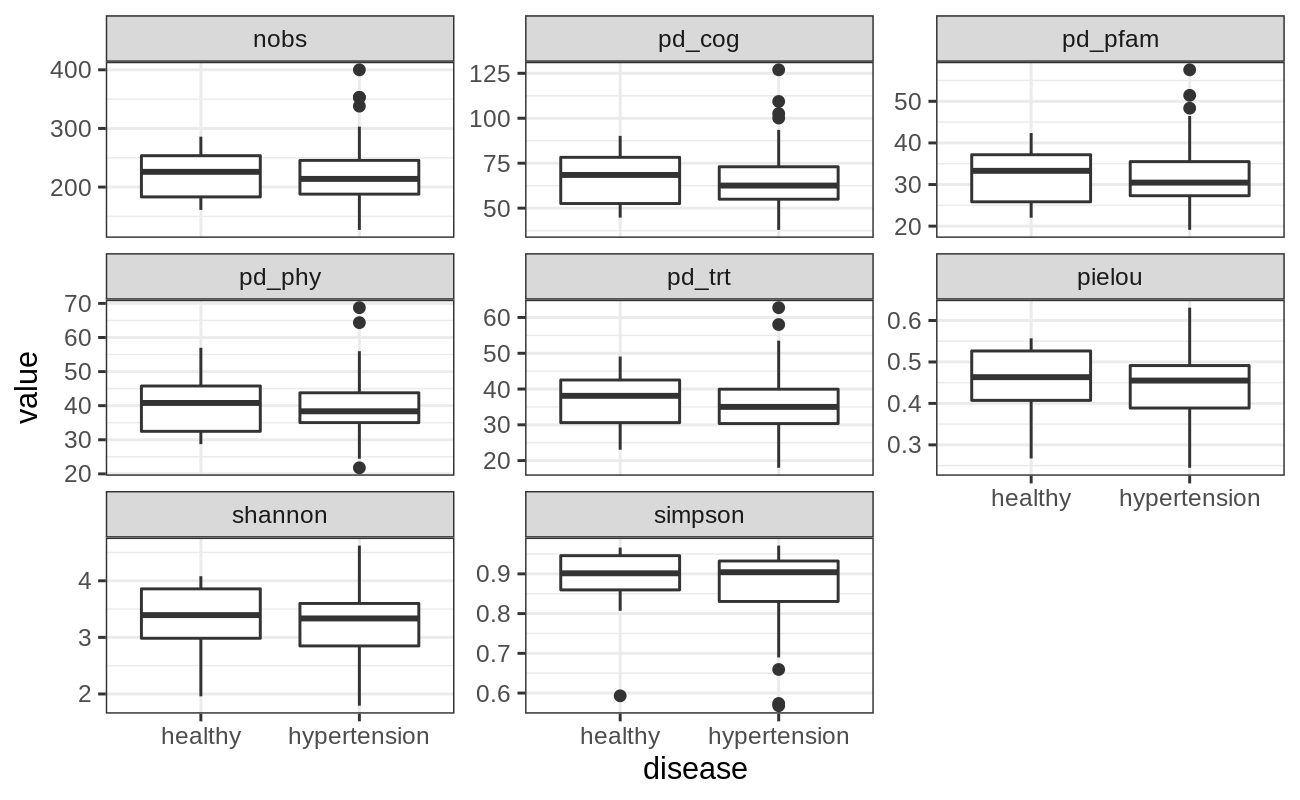

In [61]:
# plotting diversity
p = alpha_div %>%
    ggplot(aes(disease, value)) +
    geom_boxplot() +
    facet_wrap(~ measure, scales='free_y') +
    theme_bw()
p.dims(6.5,4)
plot(p)

# Calculate MPD & MNTD

* Using phylomeasures R package

In [72]:
# mean abundances
taxon_abund = brk_jw %>% apply(2, mean) %>% as.numeric
taxon_abund = taxon_abund * 100
names(taxon_abund) = colnames(brk_jw)
taxon_abund %>% length
taxon_abund %>% summary

[1] 1520

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000000  0.000200  0.001325  0.065783  0.010022 13.330110 

In [73]:
# converting count matrix to pres-abs
m = brk_jw %>% 
        apply(1, function(x) ifelse(x > 0, 1, 0)) %>% 
        t %>% as.data.frame
m

,s__Pectobacterium_sp003028395,s__Prevotella_salivae,s__Eubacterium_F_sp002431395,s__Prevotella_sp002353485,s__CAG-269_sp000435535,s__Mucilaginibacter_oryzae,s__Pauljensenia_sp000411415,s__Bacteroides_A_ilei,s__Lawsonibacter_sp900066645,s__Blautia_sp001304935,⋯,s__Psychrobacter_cibarius,s__Pseudocitrobacter_sp000330845,s__Phascolarctobacterium_faecium,s__Flavonifractor_sp002159455,s__Prevotella_intermedia,s__Bacteroides_B_dorei,s__Clostridium_AG_cavendishii,s__Lancefieldella_parvula,s__Prevotella_sp900316985,s__CAG-307_sp001916215
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H1F512951,0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,1,0,0,0,0
H1M313811,0,0,0,0,0,0,0,0,1,0,⋯,0,0,1,0,0,1,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612743,0,0,0,0,0,0,0,1,1,0,⋯,0,0,1,0,0,1,0,0,0,0
nHM612836,0,0,0,0,0,0,0,1,1,0,⋯,0,1,1,0,0,1,0,0,0,0


In [74]:
# checking overlap
intersect(trees[['gtdb_phy']]$tip.label, colnames(m)) %>% length
intersect(trees[['gtdb_phy']]$tip.label, names(taxon_abund)) %>% length

[1] 1520

[1] 1520

## MNTD

In [79]:
#' standardized PD per tree
mntd_query = function(tree_name, trees, matrix, standardize, null.model,
                     abundance.weights, reps, seed){
    res = mntd.query(trees[[tree_name]], 
                      matrix=matrix, 
                      standardize=standardize, 
                      null.model=null.model,
                      abundance.weights=abundance.weights, 
                      reps=reps, 
                      seed=seed)
    res = data.frame(Sample = rownames(m),
                     MNTD = res,
                     tree = tree_name)
    return(res)
}

## test
mntd_query('gtdb_phy', trees_fu, matrix=m, standardize = TRUE, 
           null.model = 'frequency.by.richness', 
           abundance.weights = taxon_abund,
           reps = 10, seed = random_seed)

Sample,MNTD,tree
<chr>,<dbl>,<chr>
H1F512951,-7.231310,gtdb_phy
H1M313811,-3.925492,gtdb_phy
⋮,⋮,⋮
nHM612743,0.7645729,gtdb_phy
nHM612836,1.6317618,gtdb_phy


In [80]:
# standardized MNTD
mntd_res = trees %>% names %>%
    lapply(mntd_query, 
           trees=trees_fu, 
           matrix = m, 
           standardize = TRUE, 
           null.model = 'frequency.by.richness',
           abundance.weights = taxon_abund,
           reps = 100, 
           seed = random_seed) %>%
    do.call(rbind, .)
mntd_res

Sample,MNTD,tree
<chr>,<dbl>,<chr>
H1F512951,-7.231310,gtdb_phy
H1M313811,-3.925492,gtdb_phy
⋮,⋮,⋮
nHM612743,-3.568075,pfam_phy
nHM612836,-7.448218,pfam_phy


## MPD

In [81]:
#' standardized PD per tree
mpd_query = function(tree_name, trees, matrix, standardize, null.model,
                     abundance.weights, reps, seed){
    res = mpd.query(trees[[tree_name]], 
                      matrix=matrix, 
                      standardize=standardize, 
                      null.model=null.model,
                      abundance.weights=abundance.weights, 
                      reps=reps, 
                      seed=seed)
    res = data.frame(Sample = rownames(m),
                     MPD = res,
                     tree = tree_name)
    return(res)
}

In [82]:
# standardized MPD
mpd_res = trees %>% names %>%
    lapply(mpd_query, 
           trees=trees_fu, 
           matrix = m, 
           standardize = TRUE, 
           null.model = 'frequency.by.richness',
           abundance.weights = taxon_abund,
           reps = 100, 
           seed = random_seed) %>%
    do.call(rbind, .)
mpd_res

Sample,MPD,tree
<chr>,<dbl>,<chr>
H1F512951,-11.749062,gtdb_phy
H1M313811,-5.647312,gtdb_phy
⋮,⋮,⋮
nHM612743,-3.233230,pfam_phy
nHM612836,-6.272127,pfam_phy


## Summary

In [85]:
# joining
ecophy = mntd_res %>%
    inner_join(mpd_res, c('Sample', 'tree')) %>%
    pivot_longer(cols=c(-Sample, -tree), names_to='measure', values_to='value') %>%
    inner_join(meta, c('Sample'))
ecophy

Sample,tree,measure,value,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
H1F512951,gtdb_phy,MNTD,-7.23131,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
H1F512951,gtdb_phy,MPD,-11.74906,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612836,pfam_phy,MNTD,-7.448218,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE
nHM612836,pfam_phy,MPD,-6.272127,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE


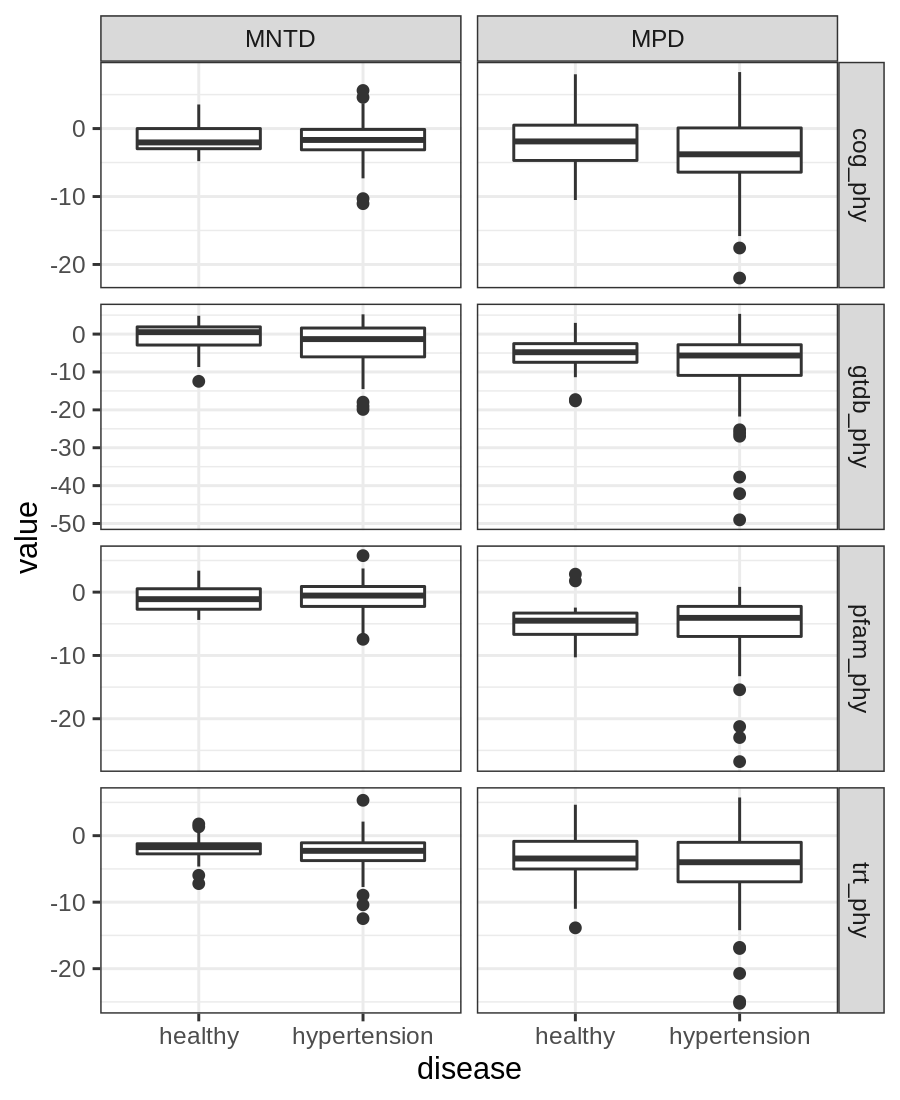

In [88]:
# plotting diversity
p = ecophy %>%
    ggplot(aes(disease, value)) +
    geom_boxplot() +
    facet_grid(tree ~ measure, scales='free_y') +
    theme_bw()
p.dims(4.5,5.5)
plot(p)

# Beta diversity

In [104]:
calc_beta_div = function(method, df, tree = NULL, threads = 1){
    vegDists = c("manhattan", "euclidean", "canberra", "clark", 
        "bray", "kulczynski", "jaccard", "gower", "altGower", 
        "morisita", "horn", "mountford", "raup", "binomial", 
        "chao", "cao", "mahalanobis")
    method = method[1]
    message("Calculating distance: ", method)
    if (method %in% vegDists) {
        d = vegan::vegdist(df, method = method)
        return(d)
    }
    else if (method %in% c("wunifrac", "unifrac")) {
        options(rbiom.max.threads = as.integer(threads))
        doParallel::registerDoParallel(threads)
        if (is.null(tree)) {
            stop("tree cannot be NULL")
        }
        to_rm = setdiff(tree$tip.label, colnames(df))
        if (length(to_rm) > 0) {
            tree = ape::drop.tip(tree, to_rm)
        }
        if (length(intersect(tree$tip.label, colnames(df))) < 
            ncol(df)) {
            stop("tree tip labels and df colnames do not match!")
        }
        if (method == "wunifrac") {
            return(rbiom::unifrac(t(as.matrix(df)), tree = tree, 
                weighted = TRUE))
        }
        if (method == "unifrac") {
            return(rbiom::unifrac(t(as.matrix(df)), tree = tree, 
                weighted = FALSE))
        }
    }
    else {
        stop(paste0("Method not supported:", method))
    }
}

In [105]:
methods = c('bray', 'jaccard', 'wunifrac', 'unifrac')

In [107]:
# phylogeny
beta_div_phy = methods %>%
    lapply(calc_beta_div, df = brk_jw, tree = gtdb_phy)
names(beta_div_phy) = methods 

Calculating distance: bray

Calculating distance: jaccard

Calculating distance: wunifrac

Calculating distance: unifrac



In [108]:
# traits
beta_div_trt = methods %>%
    lapply(calc_beta_div, df = brk_jw, tree = trt_phy)
names(beta_div_trt) = methods 

Calculating distance: bray

Calculating distance: jaccard

Calculating distance: wunifrac

Calculating distance: unifrac



## PCoA

In [117]:
calc_PCoA = function(name, dist_mtx, k=2){
  dist_mtx = dist_mtx[[name]]
  # filtering NAs
  dist_mtx = as.matrix(dist_mtx)
  n_NAs = rowSums(is.na(dist_mtx)) + colSums(is.na(dist_mtx))
  n_samps = nrow(dist_mtx)
  if(n_NAs > 0){
    warning('Number of NAs in dist matrix: ', n_NAs)
    dist_mtx = dist_mtx[rowSums(is.na(dist_mtx)) == 0, colSums(is.na(dist_mtx)) == 0, drop = FALSE]
    warning('Number of samples filtered due to NAs in dist matrix: ', n_samps - nrow(dist_mtx))
  }
  # cmdscale
  pcoa = cmdscale(as.dist(dist_mtx), k=k, eig=TRUE)
  pcoa[['name']] = name
  return(pcoa)
}

In [118]:
tidy_PCoA = function(pcoa, k=3){
  name = pcoa$name
  df = pcoa$points %>% as.data.frame
  if(ncol(df) < k){
    k = ncol(df)
  }
  df = df[,1:k]
  colnames(df) = gsub('^', 'PC', 1:k)
  for(i in 1:k){
    x = glue::glue('PC{k}_perc_exp', k=i)
    df[,x] = as.vector(pcoa$eig[i])/sum(pcoa$eig) * 100
  }
  df$sample = rownames(df)
  df$name = name
  return(df)
}

In [122]:
# PCoA
pcoa_phy = beta_div_phy %>% names %>%
    lapply(calc_PCoA, beta_div_phy) %>%
    lapply(tidy_PCoA) %>%
    bind_rows %>%
    mutate(tree = 'phylogeny')
pcoa_phy

Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”


,PC1,PC2,PC1_perc_exp,PC2_perc_exp,sample,name,tree
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
H1F512951...1,-0.4191188,0.15948027,27.82328,9.521338,H1F512951,bray,phylogeny
H1M313811...2,-0.4238379,0.01385051,27.82328,9.521338,H1M313811,bray,phylogeny
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612743...399,0.13150095,0.08984366,14.80901,13.79411,nHM612743,unifrac,phylogeny
nHM612836...400,0.04505108,0.07986345,14.80901,13.79411,nHM612836,unifrac,phylogeny


In [123]:
# PCoA
pcoa_trt = beta_div_trt %>% names %>%
    lapply(calc_PCoA, beta_div_phy) %>%
    lapply(tidy_PCoA) %>%
    bind_rows %>%
    mutate(tree = 'trait')
pcoa_trt

Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (n_NAs > 0) {:
“the condition has length > 1 and only the first element will be used”


,PC1,PC2,PC1_perc_exp,PC2_perc_exp,sample,name,tree
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
H1F512951...1,-0.4191188,0.15948027,27.82328,9.521338,H1F512951,bray,trait
H1M313811...2,-0.4238379,0.01385051,27.82328,9.521338,H1M313811,bray,trait
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHM612743...399,0.13150095,0.08984366,14.80901,13.79411,nHM612743,unifrac,trait
nHM612836...400,0.04505108,0.07986345,14.80901,13.79411,nHM612836,unifrac,trait


In [127]:
# merging all & adding metadata
pcoa_all = bind_rows(pcoa_phy, pcoa_trt) %>%
    inner_join(meta, c('sample'='Sample'))
pcoa_all

PC1,PC2,PC1_perc_exp,PC2_perc_exp,sample,name,tree,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
-0.4191188,0.15948027,27.82328,9.521338,H1F512951,bray,phylogeny,LiJ_2017,H1F512951,hypertension,hypertension,NA,,NA,TRUE
-0.4238379,0.01385051,27.82328,9.521338,H1M313811,bray,phylogeny,LiJ_2017,H1M313811,pre-hypertension,hypertension,NA,,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.13150095,0.08984366,14.80901,13.79411,nHM612743,unifrac,trait,LiJ_2017,nHM612743,control,healthy,NA,,NA,TRUE
0.04505108,0.07986345,14.80901,13.79411,nHM612836,unifrac,trait,LiJ_2017,nHM612836,pre-hypertension,hypertension,NA,,NA,TRUE


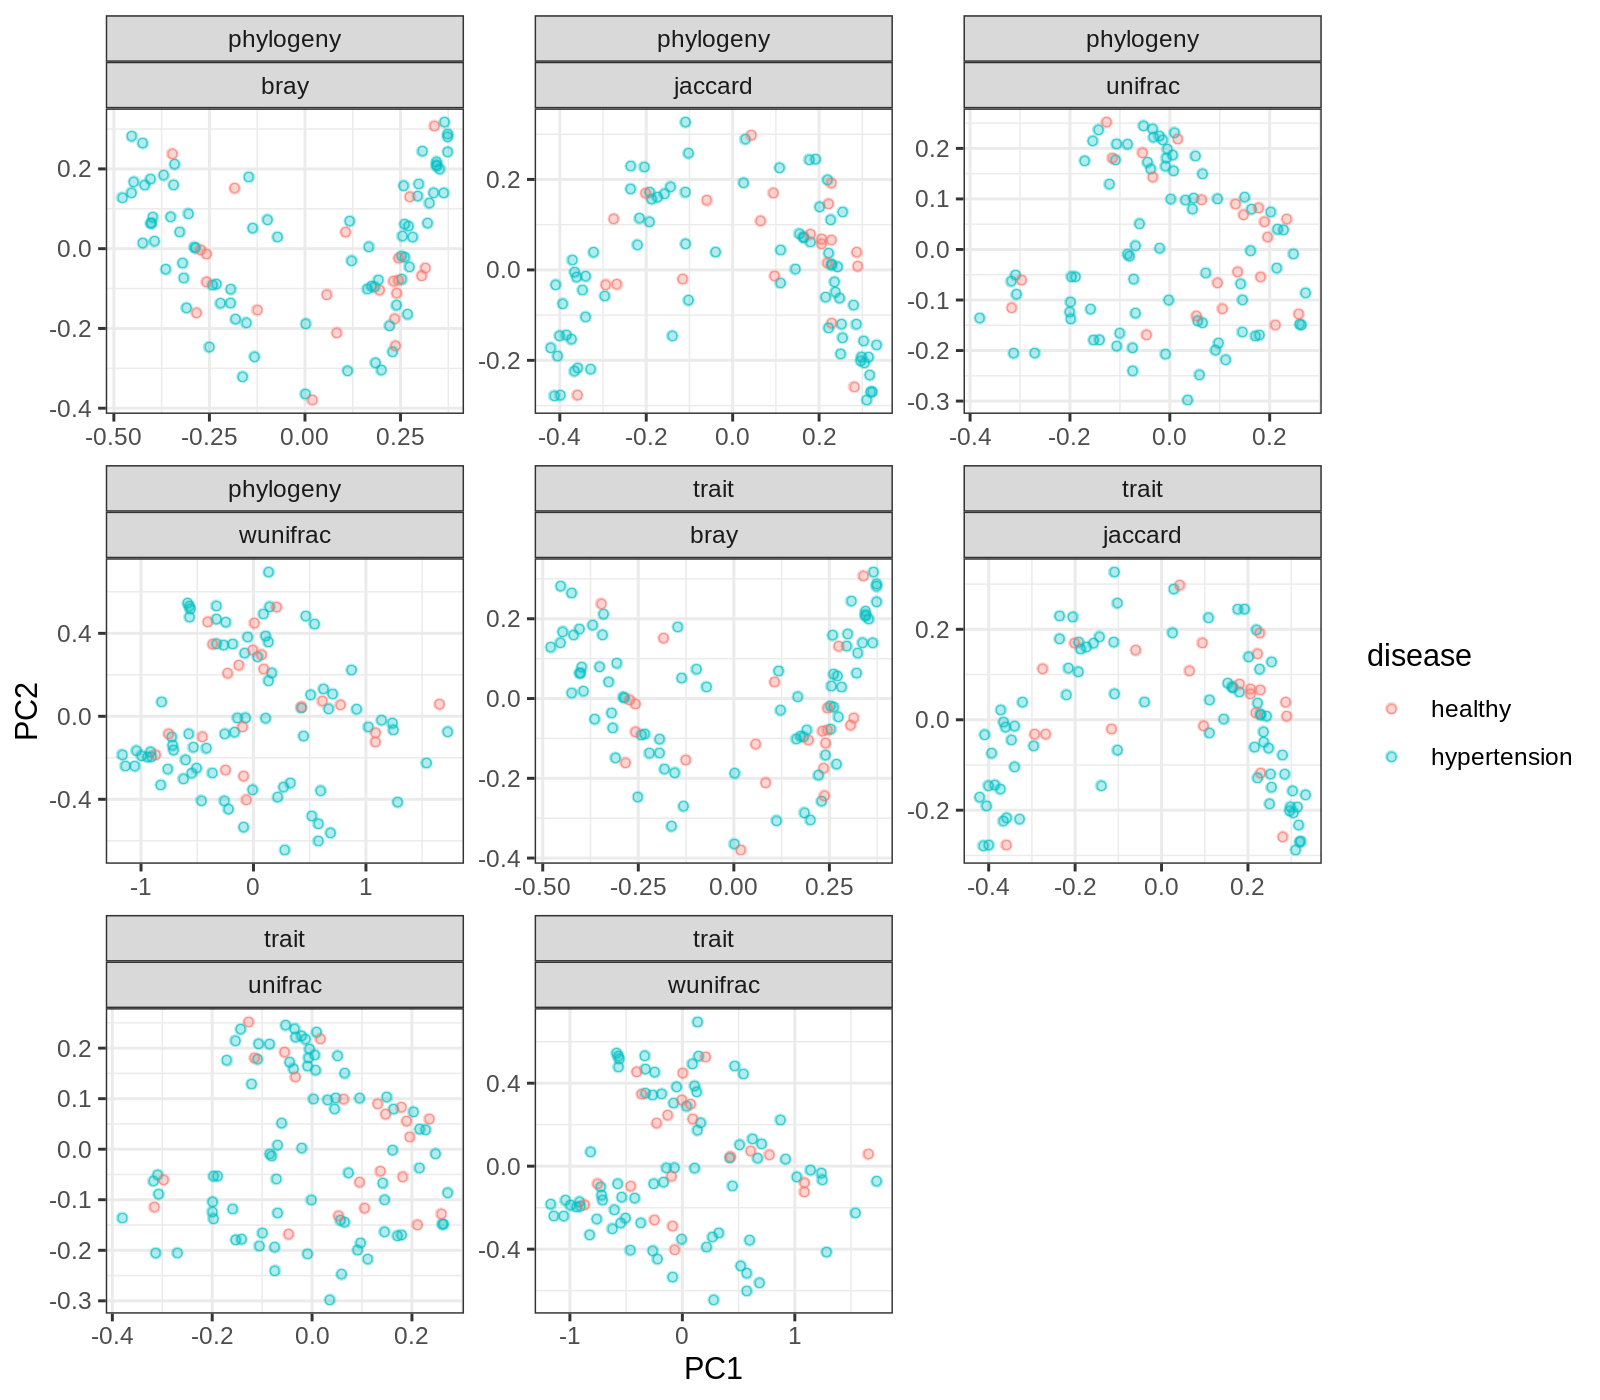

In [133]:
# plotting
p = pcoa_all %>%
    ggplot(aes(PC1, PC2, color=disease)) +
    geom_point(alpha=0.3) +
    geom_point(alpha=0.6, shape='O') +
    facet_wrap(tree ~ name, scales='free') +
    theme_bw()
p.dims(8,7)
plot(p)

# sessionInfo

In [89]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects2/global_metagenome_diversity/envs/phyloseq-phy/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] PhyloMeasures_2.1 vegan_2.5-7       lattice_0.20-45   permute_0.9-5    
[5] ape_5.5           qs_0.25.1         ggplot2_3.3.5     tidyr_1.1.4      
[9] dplyr_1.0.7      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7              digest_0.6.28           fo